# QuadraQA: Exploration Notebook

This notebook explores the implementation of the question answering system using PyTorch and Transformers.


## 1. Environment Setup


In [1]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import nltk
from nltk.tokenize import sent_tokenize
from tqdm.notebook import tqdm

Download NLTK data


In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /home/carlos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/carlos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Verify the download was successful


In [3]:
try:
    test_text = "This is a test. This is another text"
    tokens = sent_tokenize(test_text)

    print("NLTK punkt tokenizer successfully loaded.")
    print(f"Sample tokenization: {tokens}")

except LookupError as e:
    print(f"Error loading NLTK punkt tokenizer: {e}")
    print("Will use a simple fallback tokenizer if needed")

NLTK punkt tokenizer successfully loaded.
Sample tokenization: ['This is a test.', 'This is another text']


Check for GPU availability


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Model Exploration


In [5]:
models_to_test = [
    "deepset/roberta-base-squad2",
    "distilbert-base-cased-distilled-squad",
    "facebook/bart-large-finetuned-squadv1",
]

Simple text example


In [6]:
test_context = """
PyTorch is an open source machine learning framework based on the Torch library,
used for applications such as computer vision and natural language processing, 
originally developed by Meta AI and now part of the Linux Foundation umbrella.
It is free and open-source software released under the Modified BSD license.
Although the Python interface is more polished and the primary focus of development,
PyTorch also has a C++ interface.

A number of pieces of deep learning software are built on top of PyTorch,
including Tesla Autopilot, Hugging Face's Transformers, PyTorch Lightning, and
Catalyst. PyTorch provides two high-level features: Tensor computing with strong 
acceleration via graphics processing units (GPUs) and deep neural networks 
built on a tape-based automatic differentiation system.
"""

In [7]:
test_questions = [
    "Who developed PyTorch?",
    "What license is PyTorch released under?",
    "Does PyTorch support GPU acceleration?",
    "What is PyTorch Lightning?",
]

In [8]:
results = {}
for model_name in models_to_test:
    print(f"\nTesting model: {model_name}")

    try:
        # Load model
        qa_pipeline = pipeline(
            "question-answering",
            model=model_name,
            tokenizer=model_name,
            device=0 if torch.cuda.is_available() else -1,
        )

        # Process questions
        model_results = []
        for question in test_questions:
            result = qa_pipeline(question=question, context=test_context)

            print(f"Q: {question}")
            print(f"A: {result['answer']} (score: {result['score']:.4f})")

            model_results.append(result)

        results[model_name] = model_results

    except Exception as e:
        print(f"Error with model {model_name}: {e}")


Testing model: deepset/roberta-base-squad2


Device set to use cuda:0


Q: Who developed PyTorch?
A: Meta AI (score: 0.9909)
Q: What license is PyTorch released under?
A: Modified BSD (score: 0.6777)
Q: Does PyTorch support GPU acceleration?
A: Tensor computing with strong 
acceleration (score: 0.0510)
Q: What is PyTorch Lightning?
A: Hugging Face's Transformers (score: 0.0005)

Testing model: distilbert-base-cased-distilled-squad


Device set to use cuda:0


Q: Who developed PyTorch?
A: Meta AI (score: 0.9981)
Q: What license is PyTorch released under?
A: Modified BSD (score: 0.4620)
Q: Does PyTorch support GPU acceleration?
A: graphics processing units (score: 0.3358)
Q: What is PyTorch Lightning?
A: an open source machine learning framework (score: 0.6210)

Testing model: facebook/bart-large-finetuned-squadv1
Error with model facebook/bart-large-finetuned-squadv1: facebook/bart-large-finetuned-squadv1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`


## 3. Document Processing Exploration


In [9]:
def split_into_chunks(text: str, chunk_size: int = 512, overlap: int = 50):
    """
    Split text into overlapping chunks
    """

    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence.split())

        if current_length + sentence_length <= chunk_size:
            current_chunk.append(sentence)
            current_length += sentence_length

        else:
            chunks.append(" ".join(current_chunk))

            # Start a new chunk overlap
            overlap_tokens = (
                current_chunk[-3:] if len(current_chunk) > 3 else current_chunk
            )
            current_chunk = overlap_tokens + [sentence]
            current_length = sum(len(s.split()) for s in current_chunk)

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

Testing the chunking function


In [10]:
longer_text = test_context * 5
chunks = split_into_chunks(longer_text, chunk_size=100, overlap=20)

In [11]:
print(f"Original text length: {len(longer_text.split())} words")
print(f"Number of chunks: {len(chunks)}")
for i, chunk in enumerate(chunks[:3]):  # Show first 3 chunks
    print(f"\nChunk {i+1} length: {len(chunk.split())} words")
    print(chunk[:100] + "...")

Original text length: 590 words
Number of chunks: 22

Chunk 1 length: 92 words

PyTorch is an open source machine learning framework based on the Torch library,
used for applicati...

Chunk 2 length: 81 words
It is free and open-source software released under the Modified BSD license. Although the Python int...

Chunk 3 length: 106 words
Although the Python interface is more polished and the primary focus of development,
PyTorch also ha...


## 4. Implementing a Long Document QA System


In [12]:
class LongDocQA:
    def __init__(self, model_name="deepset/roberta-base-squad2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_name)
        self.qa_pipeline = pipeline(
            "question-answering",
            model=self.model,
            tokenizer=self.tokenizer,
            device=0 if torch.cuda.is_available() else -1,
        )

    def answer_question(self, question, context, top_k=3):
        """"""

        max_length = (
            self.tokenizer.model_max_length - len(self.tokenizer.encode(question)) - 5
        )

        if len(self.tokenizer.encode(context)) > max_length:
            return self._process_long_question(question, context, top_k)

        return self.qa_pipeline(question=question, context=context)

    def _process_long_question(self, question, context, top_k):
        """"""

        chunks = split_into_chunks(context, chunk_size=384, overlap=50)
        candidate_answers = []

        for chunk in chunks:
            try:
                result = self.qa_pipeline(question=question, context=chunk)
                candidate_answers.append(result)

            except Exception as e:
                print(f"Error processing chunk: {e}")

        # Sort by confidence score
        candidate_answers.sort(key=lambda x: x["score"], reverse=True)
        return candidate_answers[:top_k]

Test the long document QA


In [13]:
qa_system = LongDocQA()
test_long_doc = test_context * 10

Device set to use cuda:0


In [14]:
for question in test_questions:
    answers = qa_system.answer_question(question, test_long_doc, top_k=1)
    if isinstance(answers, list):
        answer = answers[0]

    else:
        answer = answers

    print(f"\nQ: {question}")
    print(f"A: {answer['answer']} (score: {answer['score']:.4f})")

Token indices sequence length is longer than the specified maximum sequence length for this model (1772 > 512). Running this sequence through the model will result in indexing errors



Q: Who developed PyTorch?
A: Meta AI (score: 0.9907)

Q: What license is PyTorch released under?
A: Modified BSD (score: 0.6935)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Q: Does PyTorch support GPU acceleration?
A: Tensor computing with strong 
acceleration (score: 0.1078)

Q: What is PyTorch Lightning?
A: deep learning software (score: 0.0169)


## 5. Implementing a Semantic Search for Context Retrieval


In [15]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

In [16]:
class SemanticSearch:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        )

        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def get_embedding(self, texts):
        if isinstance(texts, str):
            texts = [texts]

        encoded_input = self.tokenizer(
            texts, padding=True, truncation=True, return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            model_output = self.model(**encoded_input)

        # Perform pooiling and return embedding
        embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"])
        embeddings = F.normalize(embeddings, p=2, dim=1)

        return embeddings

    def find_relevant_chunks(self, query, chunks, top_k=3):
        query_embedding = self.get_embedding(query)
        chunk_embeddings = self.get_embedding(chunks)

        similarities = F.cosine_similarity(
            query_embedding.unsqueeze(1), chunk_embeddings.unsqueeze(0), dim=2
        ).squeeze(0)

        top_indices = torch.argsort(similarities, descending=True)[:top_k]
        return [(chunks[idx.item()], similarities[idx].item()) for idx in top_indices]

Test semantic search on chunks


In [17]:
semantic_search = SemanticSearch()

In [18]:
example_chunks = [
    "PyTorch is an open source machine learning framework based on the Torch library.",
    "PyTorch was originally developed by Meta AI and is now part of the Linux Foundation.",
    "PyTorch is released under the Modified BSD license which is a permissive free software license.",
    "PyTorch provides tensor computation with strong GPU acceleration capabilities.",
    "Deep neural networks in PyTorch are built on a tape-based automatic differentiation system.",
    "Popular libraries built on PyTorch include Hugging Face Transformers and PyTorch Lightning.",
    "Python is the primary interface for PyTorch, but it also offers a C++ interface.",
    "Tesla uses PyTorch for its Autopilot self-driving technology development.",
]

In [19]:
test_queries = [
    "Who created PyTorch?",
    "What kind of license does PyTorch have?",
    "How does PyTorch handle GPU computing?",
    "Is PyTorch used in the automotive industry?",
]

In [20]:
for query in test_queries:
    print(f"\nQuery: {query}")
    relevant_chunks = semantic_search.find_relevant_chunks(
        query, example_chunks, top_k=2
    )
    for i, (chunk, score) in enumerate(relevant_chunks):
        print(f"Relevant chunk {i+1} (score: {score:.4f}): {chunk}")


Query: Who created PyTorch?
Relevant chunk 1 (score: 0.7249): PyTorch was originally developed by Meta AI and is now part of the Linux Foundation.
Relevant chunk 2 (score: 0.6240): PyTorch is released under the Modified BSD license which is a permissive free software license.

Query: What kind of license does PyTorch have?
Relevant chunk 1 (score: 0.7652): PyTorch is released under the Modified BSD license which is a permissive free software license.
Relevant chunk 2 (score: 0.5760): PyTorch was originally developed by Meta AI and is now part of the Linux Foundation.

Query: How does PyTorch handle GPU computing?
Relevant chunk 1 (score: 0.7468): PyTorch provides tensor computation with strong GPU acceleration capabilities.
Relevant chunk 2 (score: 0.5886): Python is the primary interface for PyTorch, but it also offers a C++ interface.

Query: Is PyTorch used in the automotive industry?
Relevant chunk 1 (score: 0.5730): Tesla uses PyTorch for its Autopilot self-driving technology dev

## 6. QuadraQA System Integration


In [21]:
class QuadraQA:

    def __init__(
        self,
        qa_model_name="deepset/roberta-base-squad2",
        embedding_model_name="sentence-transformers/all-MiniLM-L6-v2",
    ):
        self.qa_system = LongDocQA(model_name=qa_model_name)
        self.semantic_search = SemanticSearch(model_name=embedding_model_name)

        self.documents = {}
        self.document_chunks = {}
        self.next_doc_id = 0

    def add_document(self, text, title=None):
        doc_id = self.next_doc_id
        self.next_doc_id += 1

        self.documents[doc_id] = {"text": text, "title": title or f"Document {doc_id}"}

        chunks = split_into_chunks(text, chunk_size=384, overlap=50)
        self.document_chunks[doc_id] = chunks

        return doc_id

    def remove_document(self, doc_id):
        if doc_id in self.documents:
            del self.documents[doc_id]
            del self.document_chunks[doc_id]

            return True

        return False

    def _get_all_chunks(self):
        all_chunks = []
        chunk_to_doc = {}

        for doc_id, chunks in self.document_chunks.items():
            for chunk in chunks:
                chunk_idx = len(all_chunks)

                all_chunks.append(chunk)
                chunk_to_doc[chunk_idx] = doc_id

        return all_chunks, chunk_to_doc

    def answer_question(self, question, specific_doc_id=None, max_content_chunks=3):
        if specific_doc_id is not None:
            if specific_doc_id not in self.documents:
                return {"error": f"Document with ID {specific_doc_id} not found"}

            context = self.documents[specific_doc_id]["text"]
            answer = self.qa_system.answer_question(question, context, top_k=1)

            if isinstance(answer, list):
                answer = answer[0]

            return {
                "answer": answer["answer"],
                "confidence": answer["score"],
                "source_document": self.documents[specific_doc_id]["title"],
                "context": self._extract_context(context, answer["answer"]),
            }

        else:
            all_chunks, chunk_to_doc = self._get_all_chunks()
            if not all_chunks:
                return {"error": "No documents available"}

            relevant_chunks = self.semantic_search.find_relevant_chunks(
                question, all_chunks, top_k=max_content_chunks
            )

            combined_context = " ".join([chunk for chunk, _ in relevant_chunks])
            answer = self.qa_system.answer_question(question, combined_context, top_k=1)

            if isinstance(answer, list):
                answer = answer[0]

            source_docs = set()
            for i, (chunk, _) in enumerate(relevant_chunks):
                chunk_idx = all_chunks.index(chunk)
                doc_id = chunk_to_doc[chunk_idx]

                source_docs.add(self.documents[doc_id]["title"])

            return {
                "answer": answer["answer"],
                "confidence": answer["score"],
                "source_documents": list(source_docs),
                "context": self._extract_context(combined_context, answer["answer"]),
            }

    def _extract_context(self, text, answer, window_size=100):
        answer_pos = text.find(answer)
        if answer_pos == -1:
            return text[: min(500, len(text))]

        start = max(0, answer_pos - window_size)
        end = min(len(text), answer_pos + len(answer) + window_size)

        context = text[start:end]
        prefix = "..." if start > 0 else ""
        suffix = "..." if end < len(text) else ""

        return prefix + context + suffix

## 7. Testing the System


In [22]:
quadra_qa = QuadraQA()

Device set to use cuda:0


In [23]:
doc1 = """
PyTorch is an open source machine learning framework based on the Torch library,
used for applications such as computer vision and natural language processing, 
originally developed by Meta AI and now part of the Linux Foundation umbrella.
It is free and open-source software released under the Modified BSD license.
Although the Python interface is more polished and the primary focus of development,
PyTorch also has a C++ interface.

A number of pieces of deep learning software are built on top of PyTorch,
including Tesla Autopilot, Hugging Face's Transformers, PyTorch Lightning, and
Catalyst. PyTorch provides two high-level features: Tensor computing with strong 
acceleration via graphics processing units (GPUs) and deep neural networks 
built on a tape-based automatic differentiation system.
"""

In [24]:
doc1_id = quadra_qa.add_document(doc1, "PyTorch Overview")

In [25]:
doc2 = """
Transformers is a Python library that exposes pre-trained models made by Hugging Face Inc.
The library was first released in June 2019 as the successor to the pytorch-transformers and
pytorch-pretrained-bert libraries. It features careful implementation and detailed documentation
for over thousands of pretrained models in more than 100 languages. Its design goal is to abstract
away the complexity of using transformer models while maintaining their flexibility.

The library supports models developed in three deep learning frameworks: PyTorch, TensorFlow,
and JAX. It is interoperable between these frameworks: a model can be trained in one framework
and loaded for inference in another. Some of the popular model architectures implemented include
BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet, T5, and more recently GPT-3 and other large models.
"""

In [26]:
doc2_id = quadra_qa.add_document(doc2, "Transformers Library")

In [27]:
questions = [
    "Who created PyTorch?",
    "What is the Transformers library used for?",
    "Which deep learning frameworks does the Transformers library support?",
    "What are the high-level features of PyTorch?",
]

In [28]:
for question in questions:
    print(f"\nQuestion: {question}")
    answer = quadra_qa.answer_question(question)
    print(f"Answer: {answer['answer']}")
    print(f"Confidence: {answer['confidence']:.4f}")
    print(f"Source: {answer['source_documents']}")
    print(f"Context: {answer['context']}")


Question: Who created PyTorch?
Answer: Meta AI
Confidence: 0.8537
Source: ['PyTorch Overview', 'Transformers Library']
Context: ... for applications such as computer vision and natural language processing, 
originally developed by Meta AI and now part of the Linux Foundation umbrella. It is free and open-source software released under t...

Question: What is the Transformers library used for?
Answer: deep learning
Confidence: 0.0246
Source: ['PyTorch Overview', 'Transformers Library']
Context: ...nsformer models while maintaining their flexibility. The library supports models developed in three deep learning frameworks: PyTorch, TensorFlow,
and JAX. It is interoperable between these frameworks: a model can...

Question: Which deep learning frameworks does the Transformers library support?
Answer: PyTorch, TensorFlow,
and JAX
Confidence: 0.9235
Source: ['PyTorch Overview', 'Transformers Library']
Context: ...taining their flexibility. The library supports models developed in three deep

## 8. Performance Evaluation


In [29]:
from datasets import load_dataset
import evaluate
import time

In [30]:
squad_metric = evaluate.load("squad")

In [31]:
squad_dev = load_dataset("squad", split="validation")
print(f"Evaluating on {len(squad_dev)} examples from SQuAD validation set")

Evaluating on 10570 examples from SQuAD validation set


In [32]:
qa_model = LongDocQA("deepset/roberta-base-squad2")

Device set to use cuda:0


In [33]:
predictions = []
references = []
evaluation_data = []

In [34]:
start_time = time.time()

for i, example in enumerate(tqdm(squad_dev, desc="Evaluating examples")):
    question = example["question"]
    context = example["context"]
    answer_text = example["answers"]["text"][0]
    answer_start = example["answers"]["answer_start"][0]

    pred = qa_model.answer_question(question, context)
    if isinstance(pred, list):
        pred = pred[0]

    pred_id = str(len(predictions))
    predictions.append({"prediction_text": pred["answer"], "id": pred_id})
    references.append(
        {
            "answers": {"answer_start": [answer_start], "text": [answer_text]},
            "id": pred_id,
        }
    )

    evaluation_data.append(
        {
            "id": pred_id,
            "question": question,
            "context_length": len(context.split()),
            "ground_truth": answer_text,
            "prediction": pred["answer"],
            "confidence": pred["score"],
            "exact_match": 1 if pred["answer"] == answer_text else 0,
        }
    )

Evaluating examples:   0%|          | 0/10570 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [35]:
print(f"Evaluation completed in {(time.time() - start_time):.2f} seconds")
result = squad_metric.compute(predictions=predictions, references=references)
print(f"\nOverall Results:")
print(f"Exact match: {result['exact_match']:.2f}")
print(f"F1 score: {result['f1']:.2f}")

Evaluation completed in 189.01 seconds

Overall Results:
Exact match: 70.55
F1 score: 84.29


### 8.1 Aux Functions for Evaluation


In [36]:
from nltk.tokenize import RegexpTokenizer
import string

In [37]:
def normalize_answer(text):
    if text is None:
        return ""

    text = str(text).lower()
    text = "".join(ch for ch in text if ch not in set(string.punctuation))
    tokens = text.split()
    tokens = [token for token in tokens if token not in ["a", "an", "the"]]

    return " ".join(tokens)

In [38]:
def compute_exact_match(prediction, ground_truth):
    if prediction is None or ground_truth is None:
        return prediction == ground_truth

    return normalize_answer(prediction) == normalize_answer(ground_truth)

In [39]:
def compute_f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    if len(prediction_tokens) == 0 or len(ground_truth_tokens) == 0:
        return 0.0 if len(prediction_tokens) != len(ground_truth_tokens) else 1.0

    common_tokens = set(prediction_tokens) & set(ground_truth_tokens)
    if len(common_tokens) == 0:
        return 0.0

    precision = len(common_tokens) / len(prediction_tokens)
    recall = len(common_tokens) / len(ground_truth_tokens)

    if precision + recall == 0:
        return 0.0

    f1 = 2 * precision * recall / (precision + recall)
    return f1

In [40]:
def is_subspan(prediction, ground_truth):
    return normalize_answer(prediction) in normalize_answer(ground_truth)

In [41]:
def is_number_match(prediction, ground_truth):
    import re

    pred_numbers = re.findall(r"\d+", prediction)
    truth_numbers = re.findall(r"\d+", ground_truth)

    if not pred_numbers or not truth_numbers:
        return False

    return any(pn == tn for pn in pred_numbers for tn in truth_numbers)

In [42]:
def evaluate_prediction(prediction, ground_truth):
    exact = prediction == ground_truth
    norm_exact = normalize_answer(prediction) == normalize_answer(ground_truth)
    f1 = compute_f1_score(prediction, ground_truth)
    subspan = is_subspan(prediction, ground_truth) or is_subspan(
        ground_truth, prediction
    )

    number_match = is_number_match(prediction, ground_truth)

    if exact:
        quality = "exact"
        score = 1.0

    elif norm_exact:
        quality = "normalized_exact"
        score = 1.0

    elif f1 > 0.8:
        quality = "close_match"
        score = 0.9

    elif f1 > 0.5:
        quality = "partial_match"
        score = 0.7

    elif subspan:
        quality = "subspan"
        score = 0.6

    elif number_match:
        quality = "number_match"
        score = 0.5

    else:
        quality = "mismatch"
        score = 0.0

    return {
        "exact": exact,
        "normalized_exact": norm_exact,
        "f1": f1,
        "subspan": subspan,
        "number_match": number_match,
        "quality": quality,
        "score": score,
    }

### 8.2 Result Analysis & Visualization


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [44]:
eval_df = pd.DataFrame(evaluation_data)
eval_df.head()

,id,question,context_length,ground_truth,prediction,confidence,exact_match
0,0,Which NFL team represented the AFC at Super Bo...,124,Denver Broncos,Denver Broncos,0.905436,1
1,1,Which NFL team represented the NFC at Super Bo...,124,Carolina Panthers,Carolina Panthers,0.853160,1
2,2,Where did Super Bowl 50 take place?,124,"Santa Clara, California",Levi's Stadium in the San Francisco Bay Area a...,0.257913,0
3,3,Which NFL team won Super Bowl 50?,124,Denver Broncos,Denver Broncos,0.726851,1
4,4,What color was used to emphasize the 50th anni...,124,gold,gold,0.770692,1


In [45]:
eval_metrics = []
for i, row in eval_df.iterrows():
    metrics = evaluate_prediction(row["prediction"], row["ground_truth"])
    eval_metrics.append(metrics)

In [46]:
metrics_df = pd.DataFrame(eval_metrics)
improved_eval_df = pd.concat([eval_df, metrics_df], axis=1)

#### 8.2.1 Summarize Results


In [47]:
print("\nImproved Evaluation Results:")
print(f"Total examples: {len(improved_eval_df)}")
print(f"Original exact match: {improved_eval_df['exact_match'].mean():.4f}")
print(f"Normalized exact match: {improved_eval_df['normalized_exact'].mean():.4f}")
print(f"Average F1 score: {improved_eval_df['f1'].mean():.4f}")
print(f"Nuanced score: {improved_eval_df['score'].mean():.4f}")


Improved Evaluation Results:
Total examples: 10570
Original exact match: 0.6422
Normalized exact match: 0.7055
Average F1 score: 0.8408
Nuanced score: 0.8575


In [48]:
quality_counts = improved_eval_df["quality"].value_counts()
print("\nQuality Breakdown:")
for quality, count in quality_counts.items():
    percentage = 100 * count / len(improved_eval_df)
    print(f"{quality}: {count} ({percentage:.1f}%)")


Quality Breakdown:
exact: 6788 (64.2%)
partial_match: 1267 (12.0%)
mismatch: 799 (7.6%)
subspan: 731 (6.9%)
normalized_exact: 669 (6.3%)
close_match: 307 (2.9%)
number_match: 9 (0.1%)


#### 8.2.2 Quality Distribution


#### 8.1.2 Compare F1 score with Exact Match

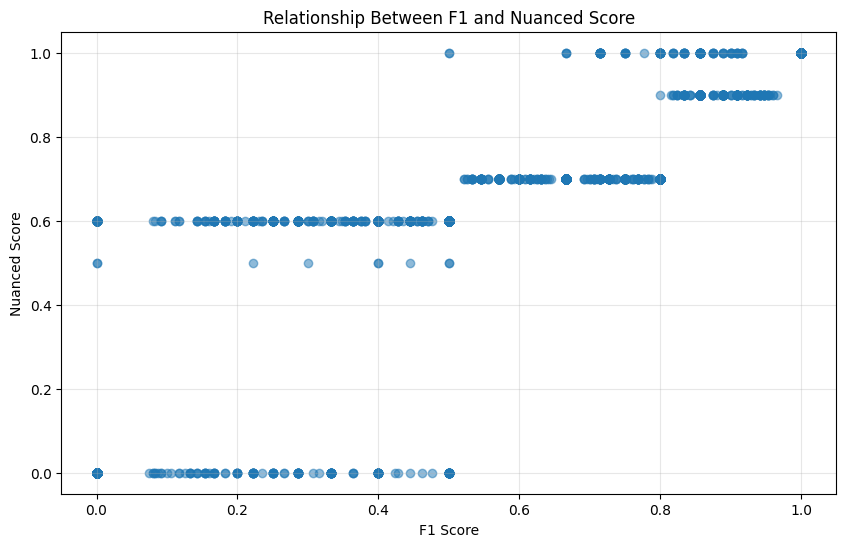

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(improved_eval_df["f1"], improved_eval_df["score"], alpha=0.5)
plt.xlabel("F1 Score")
plt.ylabel("Nuanced Score")
plt.title("Relationship Between F1 and Nuanced Score")
plt.grid(True, alpha=0.3)
plt.show()

#### 8.2.2 Performance by Context Length

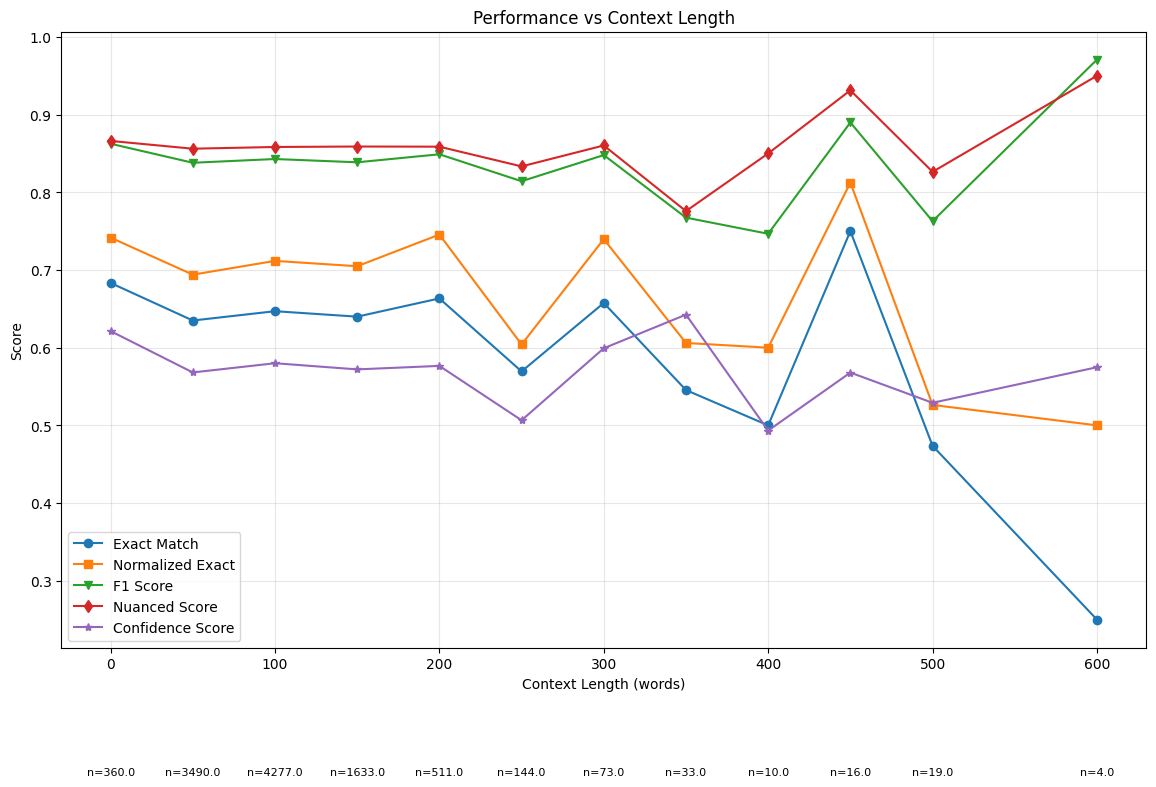

In [53]:
improved_eval_df["length_bin"] = (improved_eval_df["context_length"] // 50) * 50
context_metrics = (
    improved_eval_df.groupby("length_bin")
    .agg(
        {
            "exact": "mean",
            "normalized_exact": "mean",
            "f1": "mean",
            "score": "mean",
            "confidence": "mean",
            "id": "count",
        }
    )
    .reset_index()
)

plt.figure(figsize=(14, 8))
plt.plot(
    context_metrics["length_bin"], context_metrics["exact"], "o-", label="Exact Match"
)
plt.plot(
    context_metrics["length_bin"],
    context_metrics["normalized_exact"],
    "s-",
    label="Normalized Exact",
)
plt.plot(context_metrics["length_bin"], context_metrics["f1"], "v-", label="F1 Score")
plt.plot(
    context_metrics["length_bin"], context_metrics["score"], "d-", label="Nuanced Score"
)
plt.plot(
    context_metrics["length_bin"],
    context_metrics["confidence"],
    "*-",
    label="Confidence Score",
)

# Add count info
for i, row in context_metrics.iterrows():
    plt.text(row["length_bin"], 0.05, f'n={row["id"]}', ha="center", fontsize=8)

plt.xlabel("Context Length (words)")
plt.ylabel("Score")
plt.title("Performance vs Context Length")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 8.2.3 Confusion Analysis

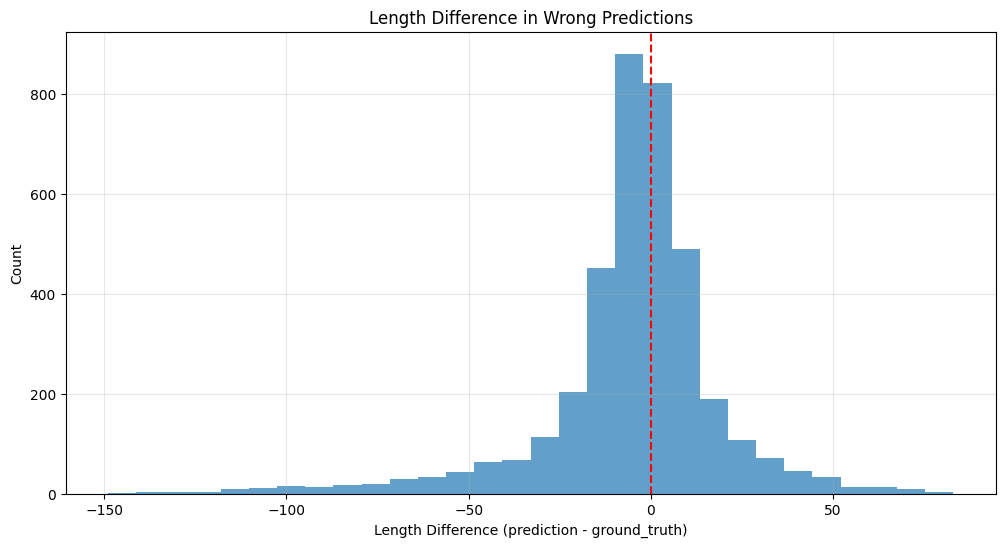

In [ ]:
error_df = improved_eval_df[improved_eval_df["exact_match"] == 0].copy()
error_df["len_diff"] = (
    error_df["prediction"].str.len() - error_df["ground_truth"].str.len()
)

error_df["len_ratio"] = error_df["prediction"].str.len() / error_df[
    "ground_truth"
].str.len().replace(0, 1)

# Are predictions typically longer or shorter than ground truth?
plt.figure(figsize=(12, 6))
plt.hist(error_df["len_diff"], bins=30, alpha=0.7)
plt.axvline(0, color="r", linestyle="--")
plt.xlabel("Length Difference (prediction - ground_truth)")
plt.ylabel("Count")
plt.title("Length Difference in Wrong Predictions")
plt.grid(True, alpha=0.3)
plt.show()

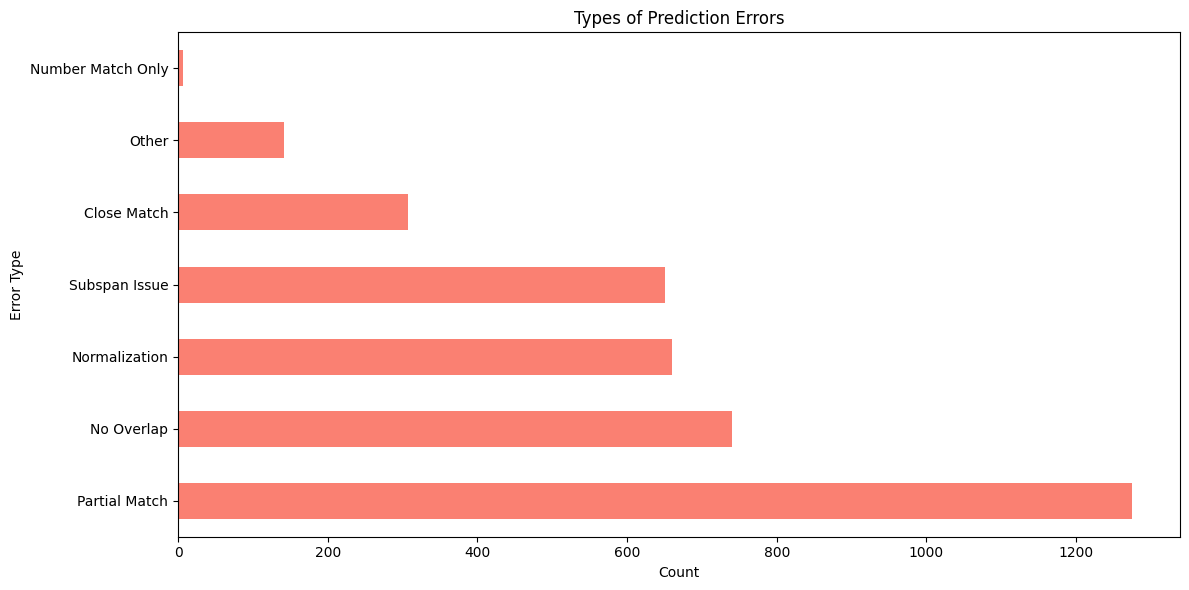

In [55]:
error_df["error_type"] = "Other"
error_df.loc[error_df["normalized_exact"] == True, "error_type"] = "Normalization"

error_df.loc[
    (error_df["f1"] > 0.8) & (error_df["normalized_exact"] == False), "error_type"
] = "Close Match"

error_df.loc[(error_df["f1"] > 0.5) & (error_df["f1"] <= 0.8), "error_type"] = (
    "Partial Match"
)

error_df.loc[(error_df["subspan"] == True) & (error_df["f1"] <= 0.5), "error_type"] = (
    "Subspan Issue"
)

error_df.loc[
    (error_df["number_match"] == True)
    & (~error_df["subspan"])
    & (error_df["f1"] <= 0.5),
    "error_type",
] = "Number Match Only"

error_df.loc[error_df["f1"] == 0, "error_type"] = "No Overlap"

# Plot error distribution
plt.figure(figsize=(12, 6))
error_counts = error_df["error_type"].value_counts()
error_counts.plot(kind="barh", color="salmon")
plt.title("Types of Prediction Errors")
plt.xlabel("Count")
plt.ylabel("Error Type")
plt.tight_layout()
plt.show()

#### 8.2.4 Confidence Calibration

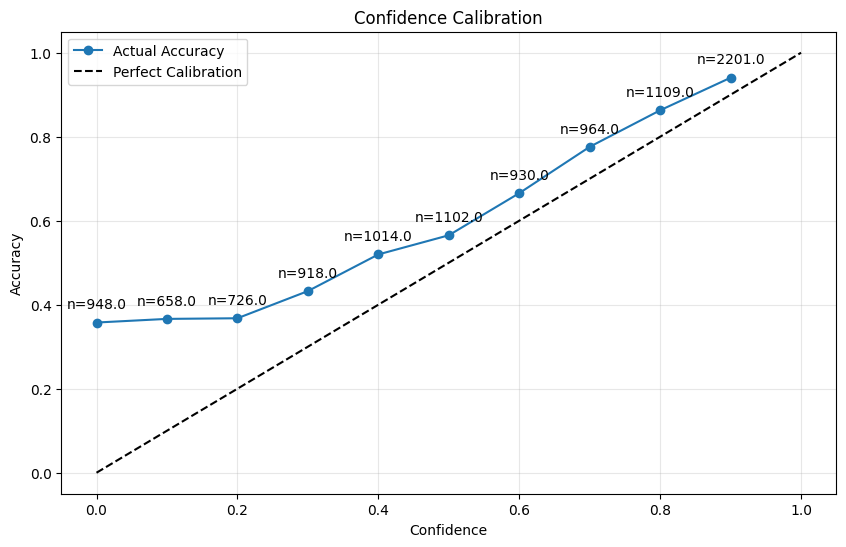

In [56]:
improved_eval_df["conf_bin"] = (improved_eval_df["confidence"] * 10).astype(int) / 10
conf_bin_metrics = (
    improved_eval_df.groupby("conf_bin")
    .agg({"exact_match": "mean", "score": "mean", "id": "count"})
    .reset_index()
)

# Plot calibration curve
plt.figure(figsize=(10, 6))
plt.plot(
    conf_bin_metrics["conf_bin"],
    conf_bin_metrics["exact_match"],
    "o-",
    label="Actual Accuracy",
)
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Confidence Calibration")
plt.legend()
plt.grid(True, alpha=0.3)

# Annotate with counts
for i, row in conf_bin_metrics.iterrows():
    plt.annotate(
        f"n={row['id']}",
        (row["conf_bin"], row["exact_match"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.show()

#### 8.2.5 Word-Level Analysis

In [57]:
from nltk.corpus import stopwords

In [58]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/carlos/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [59]:
def extract_keywords(text):
    words = text.lower().split()
    return [w for w in words if w not in stop_words and len(w) > 2]

In [60]:
improved_eval_df["question_keywords"] = improved_eval_df["question"].apply(
    extract_keywords
)

Count keyword frequency in correct and incorrect answers

In [61]:
correct_keywords = []
for keywords in improved_eval_df[improved_eval_df["exact_match"] == 1][
    "question_keywords"
]:
    correct_keywords.extend(keywords)

incorrect_keywords = []
for keywords in improved_eval_df[improved_eval_df["exact_match"] == 0][
    "question_keywords"
]:
    incorrect_keywords.extend(keywords)

Count frequencies

In [62]:
from collections import Counter

In [63]:
correct_counts = Counter(correct_keywords)
incorrect_counts = Counter(incorrect_keywords)

In [64]:
word_diff = {}
for word in set(list(correct_counts.keys()) + list(incorrect_counts.keys())):
    correct_freq = correct_counts.get(word, 0) / sum(correct_counts.values())
    incorrect_freq = incorrect_counts.get(word, 0) / sum(incorrect_counts.values())
    if correct_freq + incorrect_freq > 0.005:  # Filter for common enough words
        word_diff[word] = correct_freq - incorrect_freq

In [65]:
words = sorted(word_diff.items(), key=lambda x: abs(x[1]), reverse=True)[:20]
words_sorted = sorted(words, key=lambda x: x[1])

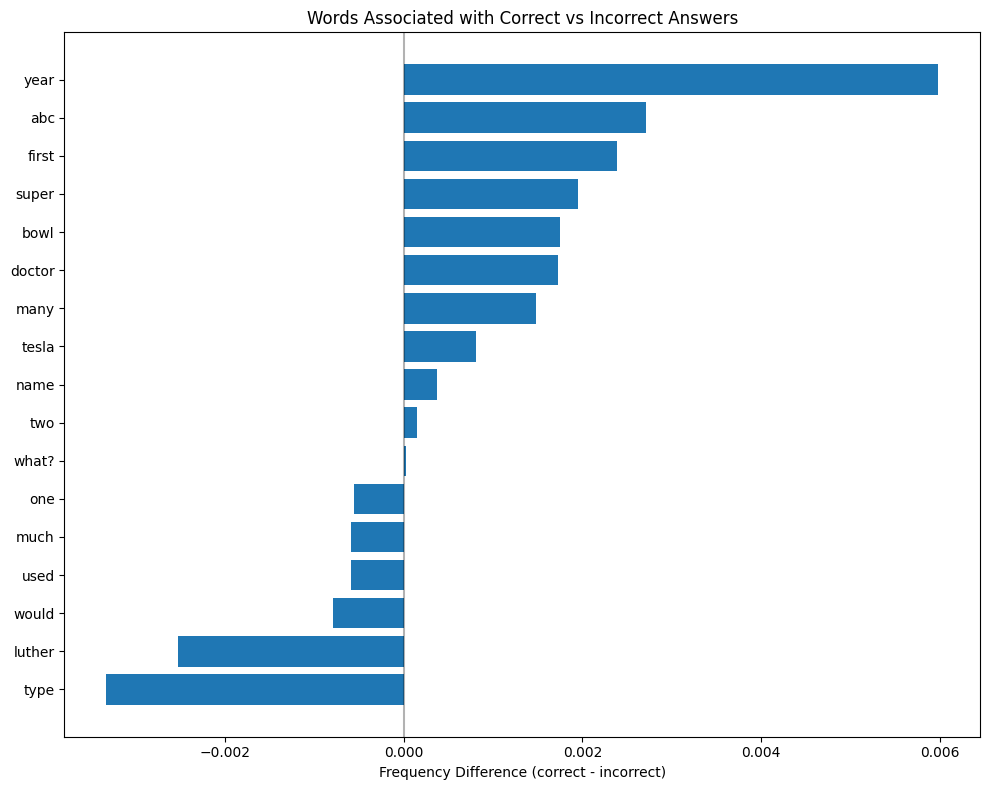

In [66]:
plt.figure(figsize=(10, 8))
plt.barh([w[0] for w in words_sorted], [w[1] for w in words_sorted])
plt.axvline(0, color="black", linestyle="-", alpha=0.3)
plt.xlabel("Frequency Difference (correct - incorrect)")
plt.title("Words Associated with Correct vs Incorrect Answers")
plt.tight_layout()
plt.show()

## 9. Saving and Loading Models


In [50]:
import os
import pickle

In [51]:
class ModelManager:
    @staticmethod
    def save_qa_system(qa_system, path):
        os.makedirs(path, exist_ok=True)

        qa_model_path = os.path.join(path, "qa_model")
        os.makedirs(qa_model_path, exist_ok=True)
        qa_system.qa_system.model.save_pretrained(qa_model_path)
        qa_system.qa_system.tokenizer.save_pretrained(qa_model_path)

        embedding_model_path = os.path.join(path, "embedding_model")
        os.makedirs(embedding_model_path, exist_ok=True)
        qa_system.semantic_search.model.save_pretrained(embedding_model_path)
        qa_system.semantic_search.tokenizer.save_pretrained(embedding_model_path)

        with open(os.path.join(path, "documents.pkl"), "wb") as f:
            pickle.dump(
                {
                    "documents": qa_system.documents,
                    "document_chunks": qa_system.document_chunks,
                    "next_doc_id": qa_system.next_doc_id,
                },
                f,
            )

        print(f"QA system saved to {path}")

    @staticmethod
    def load_qa_system(path, qa_model_name=None, embedding_model_name=None):
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path {path} does not exist")

        qa_model_path = os.path.join(path, "qa_model")
        embedding_model_path = os.path.join(path, "embedding_model")

        if os.path.exists(qa_model_path) and qa_model_name is None:
            qa_model_name = qa_model_path

        if os.path.exists(embedding_model_path) and embedding_model_name is None:
            embedding_model_name = embedding_model_path

        qa_system = QuadraQA(
            qa_model_name=qa_model_name or "deepset/roberta-base-squad2",
            embedding_model_name=embedding_model_name
            or "sentence-transformers/all-MiniLM-L6-v2",
        )

        doc_path = os.path.join(path, "documents.pkl")
        if os.path.exists(doc_path):
            with open(doc_path, "rb") as f:
                doc_data = pickle.load(f)
                qa_system.documents = doc_data["documents"]
                qa_system.document_chunks = doc_data["document_chunks"]
                qa_system.next_doc_id = doc_data["next_doc_id"]

        print(f"QA system loaded from {path}")
        return qa_system